In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from ase import Atoms
from ase.io import read
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
from ase.build import molecule
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import random
from torch_geometric.nn import global_add_pool, GATConv, CGConv
from torch_geometric.nn.models.schnet import GaussianSmearing
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pickle


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [28]:
with open("../data/tox_data.pkl", "rb") as file:
    tox_data = pickle.load(file)

with open("../data/tox_labels.pkl", "rb") as file:
    tox_labels = pickle.load(file)

In [33]:
print(tox_data)

[Data(x=[25, 10], edge_index=[2, 25], edge_attr=[25, 5], atom_data=[25, 35]), Data(x=[14, 10], edge_index=[2, 15], edge_attr=[15, 5], atom_data=[14, 35]), Data(x=[14, 10], edge_index=[2, 14], edge_attr=[14, 5], atom_data=[14, 35]), Data(x=[11, 10], edge_index=[2, 11], edge_attr=[11, 5], atom_data=[11, 35]), Data(x=[18, 10], edge_index=[2, 19], edge_attr=[19, 5], atom_data=[18, 35]), Data(x=[11, 10], edge_index=[2, 11], edge_attr=[11, 5], atom_data=[11, 35]), Data(x=[8, 10], edge_index=[2, 8], edge_attr=[8, 5], atom_data=[8, 35]), Data(x=[14, 10], edge_index=[2, 15], edge_attr=[15, 5], atom_data=[14, 35]), Data(x=[33, 10], edge_index=[2, 30], edge_attr=[30, 5], atom_data=[33, 35]), Data(x=[66, 10], edge_index=[2, 72], edge_attr=[72, 5], atom_data=[66, 35]), Data(x=[10, 10], edge_index=[2, 9], edge_attr=[9, 5], atom_data=[10, 35]), Data(x=[11, 10], edge_index=[2, 11], edge_attr=[11, 5], atom_data=[11, 35]), Data(x=[13, 10], edge_index=[2, 13], edge_attr=[13, 5], atom_data=[13, 35]), Data

In [37]:
tox_data_labels = []

for d in range(len(tox_data)):
    dd = tox_data[d]
    dd.tox = torch.tensor([tox_labels[d]], dtype=torch.float)
    tox_data_labels.append(dd)

print(tox_data_labels)

[Data(x=[25, 10], edge_index=[2, 25], edge_attr=[25, 5], atom_data=[25, 35], tox=[1]), Data(x=[14, 10], edge_index=[2, 15], edge_attr=[15, 5], atom_data=[14, 35], tox=[1]), Data(x=[14, 10], edge_index=[2, 14], edge_attr=[14, 5], atom_data=[14, 35], tox=[1]), Data(x=[11, 10], edge_index=[2, 11], edge_attr=[11, 5], atom_data=[11, 35], tox=[1]), Data(x=[18, 10], edge_index=[2, 19], edge_attr=[19, 5], atom_data=[18, 35], tox=[1]), Data(x=[11, 10], edge_index=[2, 11], edge_attr=[11, 5], atom_data=[11, 35], tox=[1]), Data(x=[8, 10], edge_index=[2, 8], edge_attr=[8, 5], atom_data=[8, 35], tox=[1]), Data(x=[14, 10], edge_index=[2, 15], edge_attr=[15, 5], atom_data=[14, 35], tox=[1]), Data(x=[33, 10], edge_index=[2, 30], edge_attr=[30, 5], atom_data=[33, 35], tox=[1]), Data(x=[66, 10], edge_index=[2, 72], edge_attr=[72, 5], atom_data=[66, 35], tox=[1]), Data(x=[10, 10], edge_index=[2, 9], edge_attr=[9, 5], atom_data=[10, 35], tox=[1]), Data(x=[11, 10], edge_index=[2, 11], edge_attr=[11, 5], ato

In [38]:
toxic_samples = [data for data in tox_data_labels if data.tox == 1]
non_toxic_samples = [data for data in tox_data_labels if data.tox == 0]

target_size = 3000
random_indices = np.random.choice(len(toxic_samples), size=target_size, replace=True)
balanced_toxic_samples = [toxic_samples[i] for i in random_indices]


random_indices_non = np.random.choice(len(non_toxic_samples), size=target_size, replace=True)
balanced_non_toxic_samples = [non_toxic_samples[i] for i in random_indices_non]

print(len(balanced_non_toxic_samples), len(balanced_toxic_samples))

balanced_dataset = balanced_non_toxic_samples + balanced_toxic_samples

np.random.shuffle(balanced_dataset)


3000 3000


In [84]:
train_data, test_data = train_test_split(balanced_dataset, test_size=0.15, random_state=48)

batch_size = 8

train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=48)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [85]:
print(len(train_loader))

574


In [138]:
edge_dim = 11
node_dim = 10

class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(GraphEncoder, self).__init__()
        self.conv1 = GATConv(input_dim+25, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads)
        self.conv3 = CGConv(input_dim+25, edge_dim)
        self.dropout = nn.Dropout(0.4)
        self.batch = nn.BatchNorm1d(edge_dim)

    def forward(self, x, edge_index, edge_attr):
        #x = self.conv1(x, edge_index, edge_attr)
        #x = nn.GELU()(x)
        #x = self.dropout(x)
        #x = self.batch(x)
        #x = self.conv2(x, edge_index, edge_attr)
        #x = nn.ReLU()(x)
        #x = self.dropout(x)
        #x = self.batch(x)
        x = self.conv3(x, edge_index, edge_attr)
        print(x.shape)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.batch(x)
        return x

class ToxicClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads):
        super(ToxicClassifier, self).__init__()
        self.pre_graph = [
            nn.Linear(input_dim+25, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, input_dim+25),
            nn.ReLU(),
        ]
        self.encoder = GraphEncoder(input_dim, hidden_dim, num_heads)
        self.fc = nn.Linear(edge_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.atom_data, data.edge_index, data.edge_attr
        x = x.float()
        #for layer in self.pre_graph:
        #    x = layer(x)
        print(len(edge_index))
        x = self.encoder(x, edge_index, edge_attr)
        x = global_add_pool(x, data.batch)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x.squeeze(dim=1)

In [139]:
# Initialize model
hidden_dim = 2
model = ToxicClassifier(node_dim, hidden_dim, 1)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [140]:
# Train model
num_epochs = 200
losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train()
    for graph in train_loader:
        optimizer.zero_grad()
        output = model(graph)
        loss = criterion(output.reshape(-1,1).to(torch.float), (graph.tox.reshape(-1,1)).to(torch.float))
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()
        #scheduler.step()
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        for graph in valid_loader:
            output_valid = model(graph)
            valid_loss_calc = criterion(output_valid.reshape(-1, 1).to(torch.float), graph.tox.reshape(-1, 1).to(torch.float))
            valid_loss += valid_loss_calc.item()
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

    if epoch % 10 == 0:
        losses.append(loss.item())
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {valid_loss}')



2


RuntimeError: mat1 and mat2 shapes cannot be multiplied (222x75 and 81x35)

In [100]:
# Evaluate model
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    correct_0s = 0
    correct_1s = 0
    total_1s = 0
    total_0s = 0
    total = 0
    tote_0 = 0
    tote_1 = 0
    for graph in test_data:
        output = model(graph)
        predicted = torch.round(output)
        total += 1
        y_true.append(int(graph.tox))
        y_pred.append(predicted)
        if predicted == 0:
            tote_0 += 1
        if predicted == 1:
            tote_1 += 1
        if predicted == int(graph.tox):
            correct += 1
        if int(graph.tox) == 1:
            total_1s += 1
            if predicted == 1:
                correct_1s += 1
        if int(graph.tox) == 0:
            total_0s += 1
            if predicted == 0:
                correct_0s += 1

    accuracy = correct / total
    print(f'Accuracy: {accuracy}')
    print(correct_0s, " correct 0 predictions out of ", total_0s)
    print(correct_1s, " correct 1 predictions out of ", total_1s)
    print("Total 0s Predicted: ", tote_0)
    print("Total 1s Predicted: ", tote_1)

Accuracy: 0.49444444444444446
209  correct 0 predictions out of  469
236  correct 1 predictions out of  431
Total 0s Predicted:  404
Total 1s Predicted:  496


In [66]:
count_0 = 0
count_1 = 0
for b in test_loader:
    for d in b.tox:
        if d == 0:
            count_0 += 1
        if d == 1:
            count_1 += 1

print(count_0, count_1)

621 579


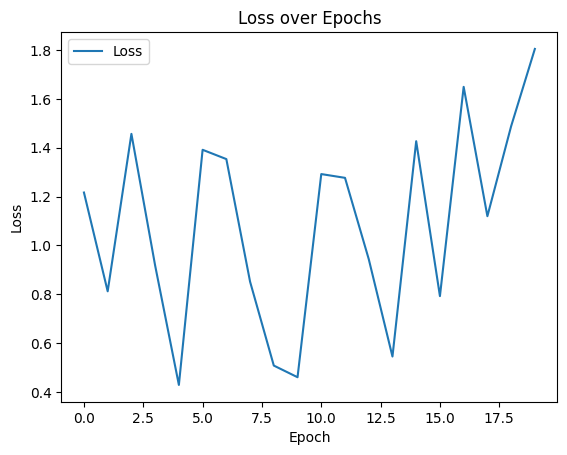

In [101]:
loss_list=[]
for i in losses:
    loss_list.append(i)

epochs = range(0, 20)

plt.plot(epochs, loss_list, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()